# PDE Modelling 

## Objectives 
* Make a model that describes cell growth and signalling at the scale of colonies 

## Model considerations 
* Species
    1. Cell density 
    1. Nutrient density 
    1. Environmental AHL (considered equal to intracellular concentration)
    1. Synthase / GFP
    1. Repressor or degradase
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Transcriptional activation
        * Basal protein expression -> scaled by repression? probably
        * Activation by internal AHL 
        * Use Hill function $$H(A(t), n, k) = \frac{A(t)^2}{k^n + A(t)^n}$$
        * Activation term, with basal expression and expression rate x
        $$X(A(t), n, k, b, x) = x\frac{A(t)^2}{k^n + A(t)^n} + b$$
    1. Transcriptional repression
        * Assume activation is AND-like, meaning that repression trumps activation
        * Use 'repression' Hill function $$H_n(R(t), n, k) = \frac{k^n}{k^n + R(t)^n}$$
        * Rather than considering protein concentrations within cells, calculate protein concentrations as produced by the bulk of cells. Expression is therefore proportional to cell density.
    1. Dilution and degradation 
        * Assume that GFP/Synthase proteins are degradation tagged
        * Degradase is not tagged, so does not have a degradation term
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xa : Synthesis rate of AHL. 
        * xs : Expression rate of protein. 
        * ha : Hill coefficient of AHL-inducible expression.
        * ka : Half-point of AHL-inducible expression. 
        * pa : Degradation rate of AHL.
        * leak : Leaky expression rate of protein. 
        


In [1]:
# imports
from __future__ import division, print_function
import numpy as np
import pandas as pd
import os
import sys
import string
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.ndimage as ndi
import matplotlib.pyplot as plt 
import matplotlib.animation as anm
import skimage.measure
import numba
import gc
from multiprocessing import Pool, Process

%load_ext line_profiler

from IPython.display import HTML

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 

In [64]:
def disk(A, center, radius):
    h, w = A.shape
    ind_mat = np.zeros((h, w, 2))
    cx, cy = center
    for i in range(h):
        ind_mat[i,:,0] = np.power(np.arange(w) - cx, 2)
    
    for i in range(w):
        ind_mat[:,i,1] = np.power(np.arange(h) - cy, 2)
    
    outmat = (ind_mat[:,:,0] + ind_mat[:,:,1]) < radius**2
    return outmat


let_dict = dict(zip(string.ascii_uppercase, np.arange(0,26)))

scale = 3
scale_s = 1 # scale/2
n_w = scale * 64 # 48
n_h = scale * 24 # 32
col_thresh = 0.05

tmax=1000

species = 10 # l_cells, c_cells, r_cells, nutrients, AHL_l, AHL_c, AHL_r, synthase_l, synthase_c, synthase_r
tup = np.array([species, n_h, n_w])
l_i, c_i, r_i, n_i, al_i, ac_i, ar_i, sl_i, sc_i, sr_i = np.arange(species)

cell_inds = [l_i, c_i, r_i]
ahl_inds = [al_i, ac_i, ar_i]
syn_inds = [sl_i, sc_i, sr_i]

# Make empty array, and tolerance arrays
atol = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7
A = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7

# set tolerances
atol[l_i,:,:]  = 1e-4*np.ones((n_h, n_w), dtype=np.float32)
atol[c_i,:,:]  = 1e-4*np.ones((n_h, n_w), dtype=np.float32)
atol[r_i,:,:]  = 1e-4*np.ones((n_h, n_w), dtype=np.float32)
atol[n_i,:,:]  = 1e-1*np.ones((n_h, n_w), dtype=np.float32)
atol[al_i,:,:] = 1e-1*np.ones((n_h, n_w), dtype=np.float32)
atol[ac_i,:,:] = 1e-1*np.ones((n_h, n_w), dtype=np.float32)
atol[ar_i,:,:] = 1e-1*np.ones((n_h, n_w), dtype=np.float32)
atol[sl_i,:,:] = 1e-5*np.ones((n_h, n_w), dtype=np.float32)
atol[sc_i,:,:] = 1e-5*np.ones((n_h, n_w), dtype=np.float32)
atol[sr_i,:,:] = 1e-5*np.ones((n_h, n_w), dtype=np.float32)

atol.shape = species*n_h*n_w

rtol = 1e-3

# Set initial conditions
# Nutrients. All at 100
A[n_i,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)

# units : L = mm, T = minutes, concentration in nM = moles / mm^3
# Da = 6 - 1.2 E-2
#LEGACY
# Params :    dx,                          Dc,    rc,  Kn,   Dn,   kn,  Da,  xa,  xs,  ha,  ka, 
#p0 = np.array([np.power((scale/2.25),2),   1e-4, 6e-3,  75,  8e-3,  2, 8e-2, 1e3, 2e-0, 2.3, 40,    
          # pa,   leak   od0
#             5e-5, 1e-8, 0.5], dtype=np.float32)

# Params :    ,           dx               Dc,    rc,  Kn,   Dn,   kn,  Da,  xa,  xs,  ha,  ka, 
p0 = np.array([np.power((scale/2.25),2),   1e-4, 6e-3,  80,  3e-2,  3, 3e-2, 8e-2, 2e1, 2.3, 40,
# hC,  kC, pa,   leak   od0
 2.3, 400, 5e-3, 1e-8, 0.5], dtype=np.float32)

# Change parameter values above. The function definitions inherit the parameter values defined here.
dx, Dc,  rc,    Kn,  Dn,   kn, Da, xa, xs, hR, kR, hC, kC, pa, leak, od0 = p0

#@numba.jit('void(float32[:,:,:],float32[:,:,:])', nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def calc_diffusion(A, D):
    # Middle
    D[:,1:-1,1:-1] = A[:,1:-1, 2:] + A[:,1:-1, :-2] + A[:,:-2, 1:-1] + A[:,2:, 1:-1] - 4*A[:,1:-1, 1:-1]
    # Edges
    D[:,0,1:-1] = A[:,0, 2:] + A[:,0, :-2] + A[:,1, 1:-1] - 3*A[:,0, 1:-1]
    D[:,-1,1:-1] = A[:,-1, 2:] + A[:,-1, :-2] + A[:,-2, 1:-1] - 3*A[:,-1, 1:-1]
    D[:,1:-1,0] = A[:,2:,0] + A[:,:-2,0] + A[:,1:-1,1] - 3*A[:,1:-1,0]
    D[:,1:-1,-1] = A[:,2:,-1] + A[:,:-2,-1] + A[:,1:-1,-2] - 3*A[:,1:-1,-1]
    # Corners
    D[:,0,0] = A[:,0,1] + A[:,1,0] - 2*A[:,0,0]
    D[:,-1,0] = A[:,-1,1] + A[:,-2,0] - 2*A[:,-1,0]
    D[:,0,-1] = A[:,0,-2] + A[:,1,-1] - 2*A[:,0,-1]
    D[:,-1,-1] = A[:,-1,-2] + A[:,-2,-1] - 2*A[:,-1,-1]

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hill(a, n, k):
    h_ma = 1 - (1 / (1 + (a/k)**n))
    return h_ma

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hillN(a, n, k):
    return 1 / (1 + (a/k)**n)

#@numba.jit('void(float32[:,:,:],float32[:,:,:],float32[:,:,:],float32[:,:])',nopython=True, cache=True)
# @numba.jit(nopython=True, cache=True)
@numba.jit(cache=True)
def calc_f(y, d_y, diff_terms, nut_avail, p0):
    dx, Dc,  rc,    Kn,  Dn,   kn, Da, xa, xs, hR, kR, hC, kC, pa, leak, od = p0
    calc_diffusion(y, diff_terms)
    
    # Growth term
    nut_avail[:] = hill(y[n_i,:,:], 2.5, Kn)
    
    # Cell growth and diffusion
    for ind in [l_i, c_i, r_i]:
        d_y[ind,:,:] = (dx)*Dc*diff_terms[ind,:,:] + rc * nut_avail * y[ind,:,:]
    
    # Nutrient consumption
    d_y[n_i,:,:] = (dx)*Dn*diff_terms[n_i,:,:] - kn * nut_avail * (y[l_i,:,:] + y[r_i,:,:] + y[c_i,:,:])
    
    # AHL production
    for cell_i, ahl_i, syn_i in zip(cell_inds, ahl_inds, syn_inds):
        d_y[ahl_i,:,:] = (dx)*Da*diff_terms[ahl_i,:,:] + xa * y[syn_i,:,:]*y[cell_i,:,:] - pa * y[ahl_i,:,:]
    
    # Synthase production
    d_y[sl_i,:,:] = xs * (y[l_i,:,:]>col_thresh) * (
        hill(y[ar_i,:,:], hR, kR) * hillN(y[sc_i,:,:], hC, kC) + 
        hill(y[ac_i,:,:], hR, kR) * hillN(y[sr_i,:,:], hC, kC)) * nut_avail
    
    d_y[sc_i,:,:] = xs * (y[c_i,:,:]>col_thresh) * (
        hill(y[ar_i,:,:], hR, kR) * hillN(y[sl_i,:,:], hC, kC) + 
        hill(y[al_i,:,:], hR, kR) * hillN(y[sr_i,:,:], hC, kC)) * nut_avail
    
    d_y[sr_i,:,:] = xs * (y[r_i,:,:]>col_thresh) * (
        hill(y[al_i,:,:], hR, kR) * hillN(y[sc_i,:,:], hC, kC) + 
        hill(y[ac_i,:,:], hR, kR) * hillN(y[sl_i,:,:], hC, kC)) * nut_avail
    

# ODE definition
#@numba.jit('float32[:](float32[:],float32[:],float32[:,:,:],float32[:,:,:],float32[:,:])', nopython=True)
@numba.jit(nopython=True)
def f(y, t, d_y, diff_terms, nut_avail, p0):
    
    y.shape = (species, n_h, n_w)
    calc_f(y, d_y, diff_terms, nut_avail, p0)
    
    return d_y.flatten()

@numba.jit
def f_ivp(t, y, d_y, diff_terms, nut_avail, p0):
    
    y.shape = (species, n_h, n_w)
    calc_f(y, d_y, diff_terms, nut_avail, p0)
    
    return d_y.flatten()


In [65]:
def prep_initial_condition(l_spots, c_spots, r_spots, ahl_spots, p0, A=A.copy()):
    dx, Dc,  rc,    Kn,  Dn,   kn, Da, xa, xs, hR, kR, hC, kC, pa, leak, od = p0

    l_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in l_spots:
        l_cells += disk(l_cells, scale*np.array(center), scale_s)*od
        
    c_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in c_spots:
        c_cells += disk(c_cells, scale*np.array(center), scale_s)*od
        
    r_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in r_spots:
        r_cells += disk(r_cells, scale*np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, scale*np.array(center), scale_s)*2.5e3

    # Set initial conditions
    for ind, cell_arr in zip([l_i, c_i, r_i], [l_cells, c_cells, r_cells]):
        A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[ar_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A

    
def sim_omnitray(p0, tmax=tmax, initial_array=A.copy()): 
    args=(np.zeros(initial_array.shape, dtype=np.float32,order='C'), 
          np.zeros(initial_array.shape, dtype=np.float32,order='C'), 
          np.zeros(initial_array.shape[1:], dtype=np.float32,order='C'), 
          p0)
    initial_array.shape = n_h*n_w*species
    print('Starting')
    #out = itg.odeint(f, A, t, args=args, atol=1e-6)
    f_lambda = lambda t, y : f_ivp(t, y, *args)
    # atol = 
    out = itg.solve_ivp(f_lambda, [0, tmax], initial_array, vectorized=True, method='RK23', 
                        atol=atol, rtol=rtol)#, t_eval=np.arange(tmax))
    print('DONE')
    return out

fn_base = "/home/jmp/data/echo_files/20170829_circuit/combo/20170829_combo_ST{}.csv"
fnames = [fn_base.format(strain) 
          for strain in [3,4]
         ]
ahl_fn = "/home/jmp/data/echo_files/20170829_circuit/AHL/20170829_combo_Cin AHL.csv"

#out = sim_omnitray(4, fnames[0], fnames[1], ahl_fn, p0)

# Take a look at one frame
out.resize((t_points,species,n_h,n_w))

print(out.shape)

plt.close('all')
fig, axs = plt.subplots(1,species, figsize=(19,5))
for i in np.arange(species):
    ax = axs[i]
    img = ax.imshow(out[-1,i,:,:], interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = fig.colorbar(mappable=img, ax=ax)
plt.show()

t_i = np.arange(im_t)[colony_mean[:,0].max() == colony_mean[:,0]]
masks, ls = skimage.measure.label(
    np.logical_xor(im_arr[t_i, 0, :, :] > 0.12, 
                   im_arr[t_i, 1, :, :] > 0.12), 
    connectivity=1, 
    return_num=True)
labels_vec[t_i] = labels
plt.imshow(masks[0])
print(ls)

In [86]:
# Try out FunctionAnimation approach
fn_base = "/home/jmp/data/echo_files/20170829_circuit/no AiiA/20170829_{}{}_ST{}.csv"
fnames = [
           [
              fn_base.format(letter, space, strain) 
              for space in [3]
              for strain in [3,4]
            ]
          for letter in ['a', 'b', 'c']
         ]

ahl_fn = "/home/jmp/data/echo_files/20170829_circuit/AHL/20170829_abc3_Cin AHL.csv"

fn_base = "/home/jmp/data/echo_files/20170829_circuit/combo/20170829_combo_ST{}.csv"
fnames = [[fn_base.format(strain) 
          for strain in [3,4]
         ]]
ahl_fn = "/home/jmp/data/echo_files/20170829_circuit/AHL/20170829_combo_Cin AHL.csv"
ahl_fn = "/home/jmp/murray/surf_2017/data/180129_redo_cascade/Echo/AHL/20170829_combo_Cin AHL.csv"

dest_wells = []
for k in np.arange(0,3):
    batch_list = []
    for j in np.arange(scale,n_h-scale,scale*2):
        for i in np.arange(scale,n_w-scale,scale*2*3):
            batch_list.append((i + k*2*scale, j))
    dest_wells.append(batch_list)

ahl_centers = [(scale+2*(1+3*(n_w//(scale*2*3))), scale)]
        
# mat = pd.read_csv(ahl_fn)
# well_strs = list(mat[['    Destination Well']].values[:,0])
# ahl_centers = [(int(w[1:]), let_dict[w[:1]]) for w in well_strs]

# dest_wells = []
# for batch in fnames:
#     batch_list = []
#     for fn in batch:
#         mat = pd.read_csv(fn)
#         well_strs = list(mat[['    Destination Well']].values[:,0])
#         colony_centers = [(int(w[1:]), let_dict[w[:1]]) for w in well_strs]
#         batch_list.append(colony_centers)
#     dest_wells.append(batch_list)

# fn_inputs = []
# for i in range(len(fnames)):
#     fn_inputs.append(dest_wells[i] + [ahl_centers, p0])

fn_inputs = dest_wells + [ahl_centers, p0]

def wrapper(p):
    initial_array = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7
    initial_array[n_i,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)
    l_spots, c_spots, r_spots, ahl_spots, p0 = p
    initial_array = prep_initial_condition(l_spots, c_spots, r_spots, [], p0, A=initial_array)
    burn_in = sim_omnitray(p0, tmax=4*60, initial_array=initial_array.copy())
    overnight_t = burn_in.t
    overnight_y = burn_in.y.T
    overnight_y.shape = (len(overnight_t), species, n_h, n_w)
    second_array = prep_initial_condition([],[],[],ahl_spots,p0,overnight_y[-1,:,:,:].copy())
    out = sim_omnitray(p0, initial_array=second_array, tmax=4*24*60)
    exp_t = out.t
    exp_y = out.y.T
    exp_y.shape = (len(exp_t), species, n_h, n_w)
    out = np.concatenate((overnight_y, exp_y), axis=0)
    t_vec = np.concatenate((overnight_t, exp_t))
    return exp_y, exp_t
    
#with Pool(3) as p:
#    res = p.map(wrapper, fn_inputs)

# a_out = wrapper(fn_inputs[0])
a_out = wrapper(fn_inputs)


Starting
DONE
Starting
DONE


In [87]:
def write_movie(out, t):
    plt.close('all')
    
    t_points, s, h, w = out.shape
    
    if len(t) < 200:
        frames = len(t)
        skip = 1
        im_arr = out[:,:,:,:]
    else:
        frames = 200
        skip = np.int(np.floor(t_points/frames))
        im_arr = out[::skip,:,:,:]
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([n_h, n_w])
    fig, axs = plt.subplots(3,2, figsize=(10,8))
    im_list = [0,0,0,0,0,0,0]
    
    # Plot cell densities
    ax = axs[0,0]
    indxs = [l_i, c_i, r_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[0,1]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[1] = im
    
    # Plot synthase densities
    ax = axs[1,0]
    indxs = [sl_i, sc_i, sr_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[2] = im
    
    # Plot AHL densities
    ax = axs[1,1]
    indxs = [al_i, ac_i, ar_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('AHLs')
    im_list[3] = im
    
    # Plot colony masks
    ax = axs[2,0]
    indxs = [l_i, c_i, r_i]
    vmax = 50
    vmin = 0
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('masks')
    im_list[4] = im
    
    # Plot synthases within masks
    ax = axs[2,1]
    indxs = [al_i, ac_i, ar_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('synthases in colonies')
    im_list[5] = im

    # animation function.  This is called sequentially
    frame_arr = np.zeros(im_arr.shape[2:])
    def animate(i):
        # Plot cell densities
        ax = axs[0,0]
        indxs = [l_i, c_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[0,1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[1,0]
        indxs = [sl_i, sc_i, sr_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[2].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[1,1]
        indxs = [al_i, ac_i, ar_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot colony masks
        ax = axs[2,0]
        indxs = [l_i, c_i, r_i]
        frame_arr = im_arr[i, indxs, :, :].sum(axis=0) > col_thresh
        frame_arr[:,:np.int(n_w/2)] = 0
        mask, labls = skimage.measure.label(frame_arr,return_num=True, connectivity=1) 
        im_list[4].set_array(mask)
        
        # Plot colony masks
        ax = axs[2,1]
        indxs = [sl_i, sc_i, sr_i]
        frame_arr = np.zeros(im_arr.shape[2:])
        for indx in indxs:
            frame_arr += im_arr[i, indx, :, :]
        mask, labls = skimage.measure.label(
                im_arr[i, indxs, :, :].sum(axis=0) > col_thresh,
                        return_num=True, connectivity=1) 
        im_list[5].set_array((mask>0)*frame_arr)
        
        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=frames)


    # Set up formatting for the movie files
    #Writer = anm.writers['ffmpeg_file']
    #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('animation_{}.mp4'.format(fn), extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
    #plt.close('all')


    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

out_names = ["a", "b", "c"]
out, t_vec = a_out

anim = write_movie(out, t_vec) #, out_names[i])
HTML(anim.to_html5_video())

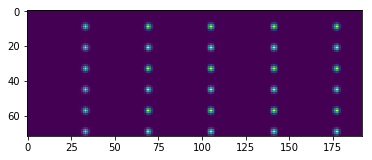

In [88]:
plt.imshow(out[0,r_i,:,:])